## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/analysisFunctions.py

## Download speech data

In [2]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [3]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835


In [4]:
trainDF.head()

,files,labels,category
0,speechData/train/dog/2275edbb_nohash_0.wav,8,dog
1,speechData/train/six/6727b579_nohash_4.wav,23,six
2,speechData/train/three/56eab10e_nohash_0.wav,14,three
3,speechData/train/one/6c9223bd_nohash_1.wav,6,one
4,speechData/train/bird/8549f25d_nohash_1.wav,7,bird


## Tensorflow 2.0

In [5]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 72kB/s 
     |████████████████████████████████| 3.1MB 42.9MB/s 
     |████████████████████████████████| 501kB 38.9MB/s 


In [6]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


## Input pipeline

In [7]:
!pip install -q python_speech_features

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 30000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False
) 


## Model

In [0]:
def lstmAttModel(input_shape=(99, 40)):
    '''
    Long-Short-Term-Memory model
    '''
    
    # Fetch input
    inputs = tf.keras.Input(shape=input_shape)
    reshape = tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(99, 40, 1))(inputs)

    # Normalization Layer
    l = tf.keras.layers.BatchNormalization()(reshape)
    
    # Convolutional Layer
    l = tf.keras.layers.Conv2D(60, kernel_size=(3, 3), padding='same', activation='relu')(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='relu')(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Lambda(lambda x: tf.keras.backend.squeeze(x,-1), name = 'squeeze_dim')(l)

    # LSTM Layer
    l = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True, dropout=0.2))(l)
    l = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True, dropout=0.2))(l)
    
    # Attention Layer
    attention = tf.keras.layers.Attention()([l, l])
    
    # Classification Layer
    outputs = tf.keras.layers.Flatten()(attention)
    outputs = tf.keras.layers.Dense(512, activation='relu')(outputs)
    outputs = tf.keras.layers.Dense(30, activation='softmax')(outputs)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [132]:
# from models import lstmModel

model = lstmAttModel()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 99, 40)]     0                                            
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 99, 40, 1)    0           input_43[0][0]                   
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 99, 40, 1)    4           reshape_19[0][0]                 
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 99, 40, 60)   600         batch_normalization_40[0][0]     
___________________________________________________________________________________________

In [133]:
EPOCHS = 25

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR])



Epoch 1/25
937/937 [==============================] - 144s 153ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.4772 - val_sparse_categorical_accuracy: 0.8591
Epoch 2/25
937/937 [==============================] - 125s 133ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.4427 - val_sparse_categorical_accuracy: 0.8821
Epoch 3/25
937/937 [==============================] - 122s 130ms/step - loss: 0.2613 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.3807 - val_sparse_categorical_accuracy: 0.9014
Epoch 4/25
937/937 [==============================] - 122s 130ms/step - loss: 0.2047 - sparse_categorical_accuracy: 0.9393 - val_loss: 0.3557 - val_sparse_categorical_accuracy: 0.9155
Epoch 5/25
937/937 [==============================] - 122s 131ms/step - loss: 0.1753 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.3000 - val_sparse_categorical_accuracy: 0.9253
Epoch 6/25
937/937 [==============================] - 122s 130ms/step - loss: 0.

## Save model and trainign history  to drive

In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [134]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/lstmModel

mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/lstmModel’: File exists


In [135]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/lstmModel/"

## Save model 
model_json = model.to_json()
with open(GDRIVE_PATH + "model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights(GDRIVE_PATH + "model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [136]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "train_results.pickle", 'rb') as handle:
    hist = pickle.load(handle)

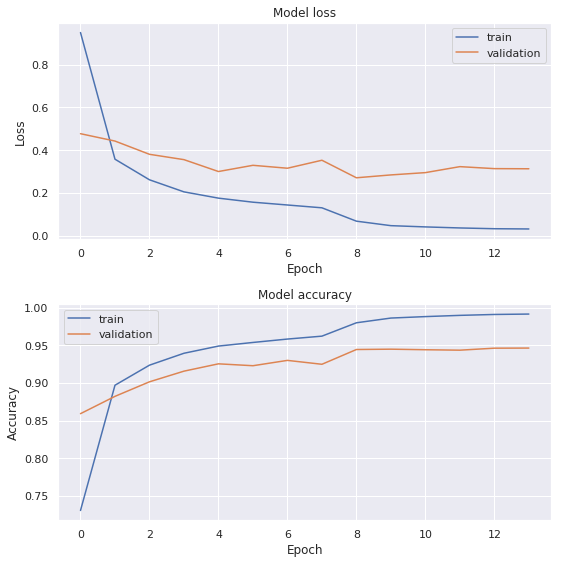

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [139]:
out = model.predict(test_data, verbose=1)

214/214 [==============================] - 13s 59ms/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [141]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.9467


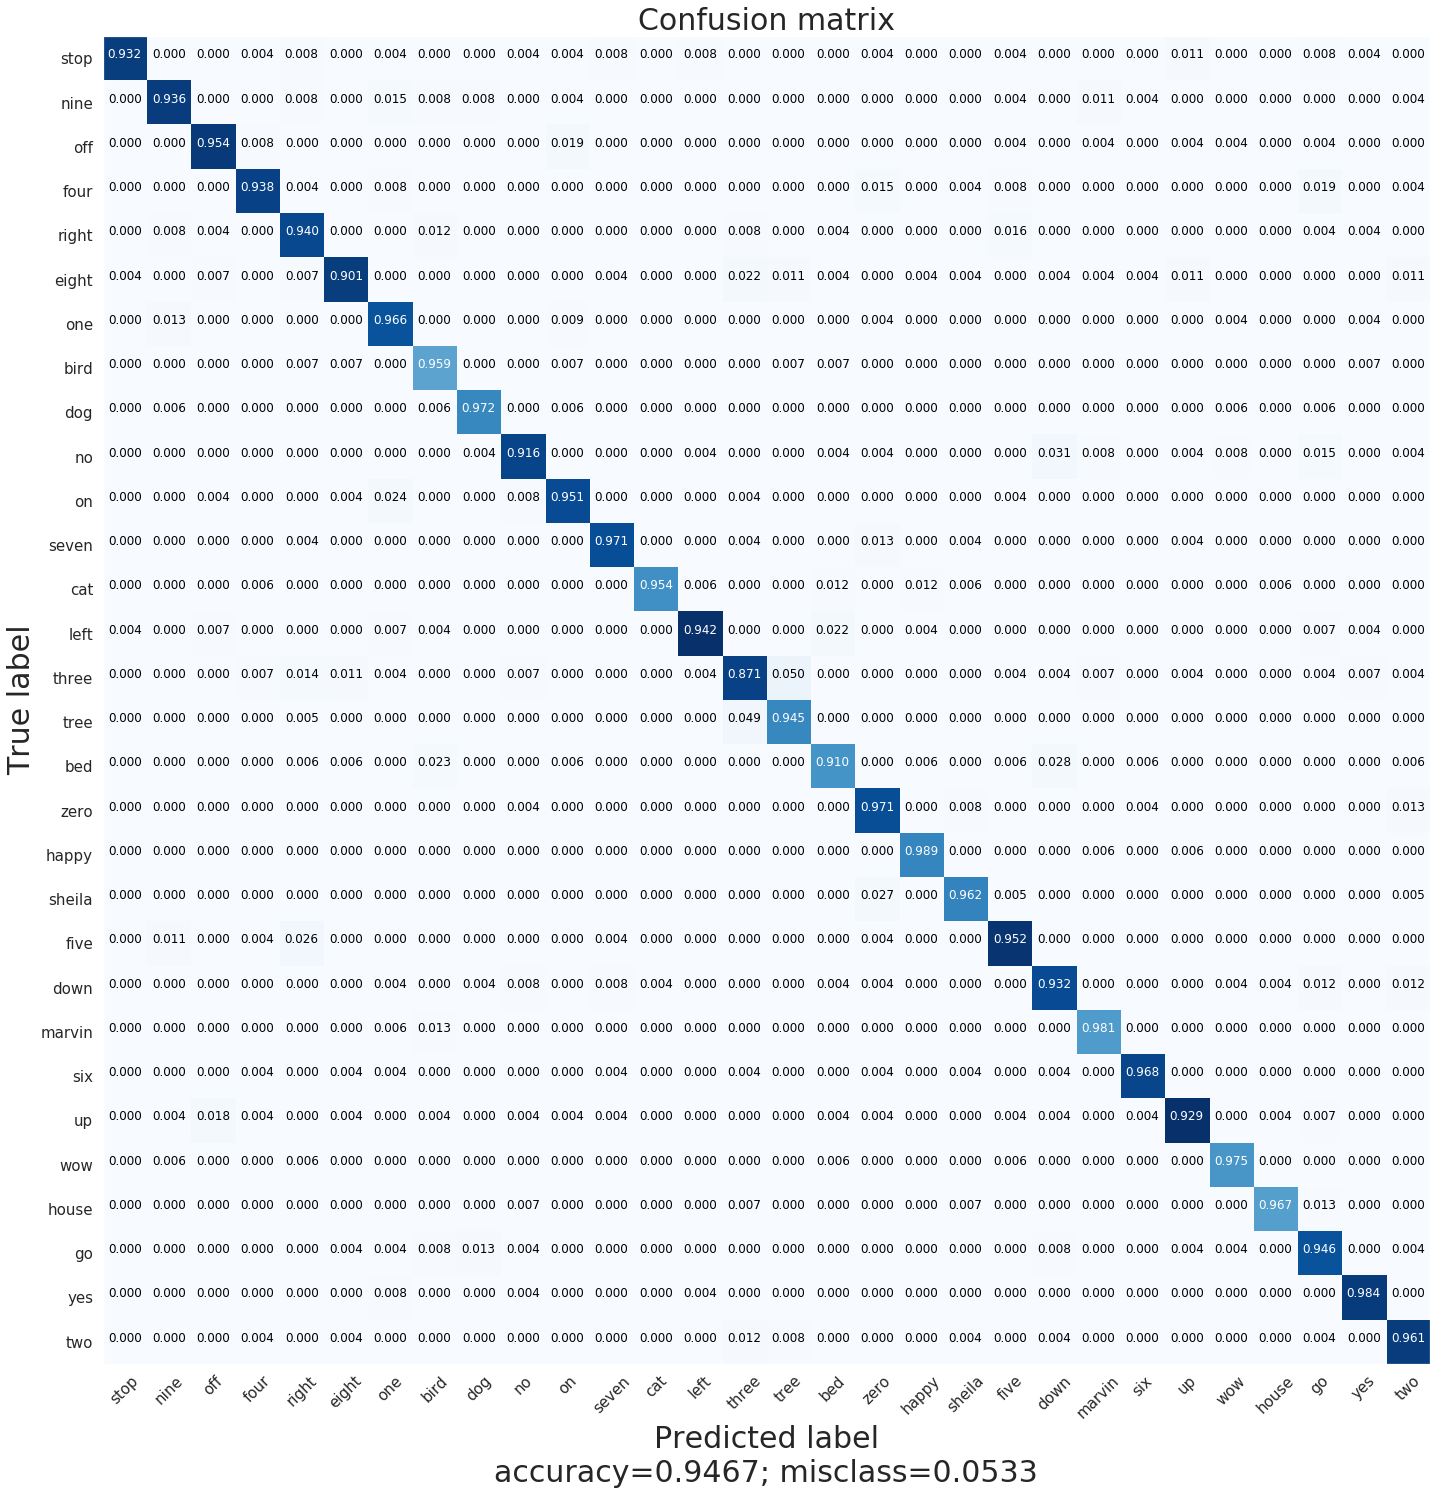

In [142]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)